In [1]:
from makedataset import makedataset
from numpy.testing._private.utils import HAS_LAPACK64
from tensorflow.python.keras.saving.save import load_model
from tensorflow.python.keras.utils.vis_utils import plot_model

import numpy as np
import matplotlib.pyplot as plt

import os 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from root_numpy import array2root
import tensorflow as tf
from tensorflow.keras import layers


Welcome to JupyROOT 6.22/00


In [3]:
data = makedataset('W2LNu10000Events_13Tev.root')

X_train = data.getGenFeatureVals()
y_train = data.getGenLabelVals()
X_star  = data.getRecoFeatureVals()

input_dim = X_train.shape[1]
print('-'*15,' dimensions of the input variables ','-'*15)
print('training   input dimensions',X_train.shape,'  ',y_train.shape)
print('predicitng input dimensions',X_star.shape)
print('-'*50)
num_pipeline = Pipeline([
    #('imputer',SimpleImputer(strategy="median")),
    ('std_scaler',StandardScaler()),
])

X_gen,X_reco = num_pipeline.fit_transform(X_train),num_pipeline.fit_transform(X_star)
M_gen  = num_pipeline.fit_transform(y_train.reshape(-1,1))

['geninvis_px', 'geninvis_py', 'geninvis_pz', 'geninvis_e', 'genmuon_px', 'genmuon_py', 'genmuon_pz', 'genmuon_e', 'muon_px', 'muon_py', 'muon_pz', 'muon_e', 'invis_px', 'invis_py', 'boson_M']
---------------  dimensions of the input variables  ---------------
training   input dimensions (10000, 8)    (10000,)
predicitng input dimensions (10000, 6)
--------------------------------------------------


In [96]:
BATCH_SIZE = 128

In [223]:
class GANreco:
    def __init__(self,genData,recoData,label):
        self.genData  = genData
        self.recoData = recoData
        self.label  = label
        self.input_dim  = genData.shape[1]
        self.latent_dim = genData.shape[1]
        
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        
        self.generator = self.build_generator(self.input_dim,self.latent_dim)
        self.discriminator = self.build_discriminator(self.input_dim)

        checkpoint_dir = './training_checkpoints'
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                        discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)

    def combine(self,t1,t2):
        return tf.concat([t1,t2],axis=1)

   # @tf.function
    def train(self, epochs):
        BATCH_SIZE = 100
        self.genData_tensor = tf.constant(X_gen,dtype=tf.float32)
        self.recoData_tensor = tf.constant(X_reco,dtype=tf.float32)
        self.label_tensor = tf.constant(M_gen,dtype=tf.float32)
        dataset = tf.data.Dataset.from_tensor_slices(self.genData_tensor).batch(BATCH_SIZE)
        recodataset = tf.data.Dataset.from_tensor_slices(self.recoData_tensor).batch(BATCH_SIZE)
        label_dataset = tf.data.Dataset.from_tensor_slices(self.label_tensor).batch(BATCH_SIZE)      
        for epoch in range(epochs):
            for feature_batch, label_batch,reco_feature_batch in zip(dataset, label_dataset,recodataset):
                if len(feature_batch) == BATCH_SIZE:
                    noise = tf.random.normal([BATCH_SIZE, self.input_dim])
            
                with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                    noiseandlabels = self.combine(noise,label_batch)
                    generated_kin = self.generator(noiseandlabels, training=True)
                    real_batch  = self.combine(feature_batch,label_batch)
                    fake_batch  = self.generate_fake_samples(generated_kin,reco_feature_batch,label_batch)
                    real_output = self.discriminator(real_batch, training=True)
                    fake_output = self.discriminator(fake_batch, training=True)
                    
                    gen_loss = self.generator_loss(fake_output)
                    disc_loss = self.discriminator_loss(real_output, fake_output)
                
                gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
                gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
                
                self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
                self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        save_model = self.generator.save('./cGANgenerator.h5')

    def predict_kin(self,noise):
        model = load_model('./cGANgenerator.h5')
        test_input = self.combine(noise,self.label_tensor)
        predictions = model(test_input, training=False)
        pred_array = predictions.numpy()
        px = self.recoData[:,-2].reshape(-1,1)
        py = self.recoData[:,-1].reshape(-1,1)
        pz = pred_array[:,-1].reshape(-1,1)
        e  = np.sqrt(px**2+py**2+pz**2)
        reco = np.concatenate((self.recoData,pz,e),axis=1)
        return reco
        
    def generate_fake_samples(self,gen_sample,reco_sample,label):
        new_te = tf.concat([reco_sample,tf.expand_dims(gen_sample[:,-3],axis=1),
                            tf.expand_dims(gen_sample[:,-2],axis=1),label],axis=1)
        return new_te
        
    def discriminator_loss(self,real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self,fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)
                                 
        
    def build_generator(self,input_dim,latent_dim):
        gen_input = layers.Input(shape=(input_dim+1,))
#         gen_ytrue = layers.Input(shape=(1,))
#         gen_concat = layers.Concatenate()([gen_input,gen_ytrue])
        layer = layers.Dense(64,activation='relu')(gen_input)
        layer = layers.Dense(256,activation='relu')(layer)
        layer = layers.Dense(64,activation='relu')(layer)
        out_layer = layers.Dense(latent_dim,activation='tanh')(layer)

        model = tf.keras.Model(gen_input,out_layer)
        return model

    def build_discriminator(self,n_inputs):
        dis_input = layers.Input(shape=(n_inputs+1,))
#         dis_ytrue = layers.Input(shape=(1,))
#         dis_concat = layers.Concatenate()([dis_input,dis_ytrue])
        layer = layers.Dense(128,activation='relu')(dis_input)
        layer = layers.Dense(64,activation='relu')(layer)
        layer = layers.Dense(32,activation='relu')(layer)
        out_layer = layers.Dense(1,activation='sigmoid')(layer)
        
        model = tf.keras.Model(dis_input,out_layer)
        return model


In [224]:
reco_obj = GANreco(genData_tensor,X_reco,label_tensor)

In [225]:
reco_obj.train(100)

In [226]:
noise = tf.random.normal([X_gen.shape[0], X_gen.shape[1]])

In [228]:
reco_vals = reco_obj.predict_kin(noise)

In [230]:
reco_mom = num_pipeline.inverse_transform(reco_vals)

In [234]:
saved_model = tf.keras.models.load_model('../data/GANinput_model.h5')

In [237]:
saved_old_model = tf.keras.models.load_model('../data/regression_model.h5')

In [235]:
y_pred = saved_model.predict(reco_vals)

In [238]:
y_pred_old = saved_old_model.predict(X_reco)

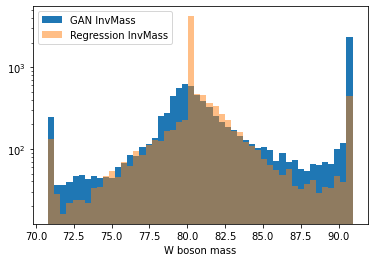

In [243]:
pred = num_pipeline.inverse_transform(y_pred)
pred_old = num_pipeline.inverse_transform(y_pred_old)
fig2,ax2 = plt.subplots()
ax2.hist(pred,50,log=True,label='GAN InvMass')
ax2.hist(pred_old,50,log=True,label='Regression InvMass',alpha=0.5)
ax2.set_xlabel('W boson mass')
ax2.legend()